# Utility algorithms:

### Recognize evolutions of the same clusers

**Metod:** Cosine simmilarity matrix, cluster alignment using local threshold

**Parameters:**
* Position
* Point count / avg
* Blair-Bliss (density) 
* Correlation coeffitience (roundness) 
* Linear trend direction 


# Phase 1: Outlier/novelty detection on sensors

### For whole map generate scores for each step's:

1) Novelty: In comparison to previous measurements from same calibration 

**Metod:**
    Streaming RRCF

**Parameters:**
* New points count / avg
* Lost points count / avg
* Number of new clusters / avg (Use cluster recognition algorithm)
* Number of lost clusters / avg
* New points in clusters count / avg
* Lost points in clusters count / avg

2) Outlierness : In comparison to other sensors / previous calibrations data

**Metod:** Batch RRCF

**Parameters:**
* Directional density imbalance (Steepness of maximum imbalance axis)
* Local density imbalance (Standard deviation of KNN distance sum)
* Total points count / total
* Number of clusters / avg
* Points in clusters / avg

# Phase 2: Sensor noise progression forecasting


### For each sensor forecast a set of measurements:

**Metod:** Holt-Winters

**Parameters:**
* Directional density imbalance (Steepness of maximum imbalance axis)
* Local density imbalance (Standard deviation of KNN distance sum)
* Total points count
* Number of clusters
* Points in clusters



In [1]:
!pip install rrcf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
import rrcf
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

# Phase 0


### Simulated data generation

In [3]:
index = 0
lines = []
blobs = []

D_MIN = 10

def make_line(h, w, line_len):
    alpha = np.random.uniform(0, np.pi)
    fun = np.poly1d([np.tan(alpha),np.random.randint(0, h)])
    start_X = np.random.randint(0, w)
    # X = np.uniform(start_X, start_X + line_len*np.cos(alpha), size=line_len)
    X = np.linspace(start_X, start_X + line_len*np.cos(alpha), num=line_len)
    Y = fun(X)
    return np.vstack((X%w, Y%h)).T.astype(int)

In [4]:
random_line = make_line(256, 256, np.abs(np.random.randint(40)))
random_line

array([[249, 230],
       [249, 231],
       [249, 232],
       [250, 233],
       [250, 234],
       [251, 236]])

In [5]:
one_line_map=np.zeros((256,256))
amplifying_factor=300
for x, y in random_line:
    one_line_map[x, y] = amplifying_factor

In [6]:
one_line_map=np.zeros((256,256))
amplifying_factor=300
one_line_map[random_line[:,0], random_line[:,1]] = amplifying_factor

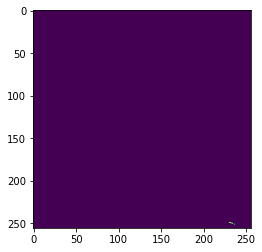

In [7]:
plt.imshow(one_line_map)

In [8]:
def make_blob(n_samples, avg_std = 5, size=256):
    return make_blobs(n_samples,
                      cluster_std=np.abs(np.random.randn()*5+1), 
                      centers=1, 
                      center_box=(0,size*0.7))[0].astype(int)

In [9]:
random_blob = make_blob(n_samples=np.abs(np.random.randint(40)),size=256)
random_blob.T

array([[ 85,  98,  93,  88,  90,  97, 102, 102,  95,  93,  98, 100],
       [102,  93, 101,  91,  97,  88,  87,  95,  94,  82,  95,  95]])

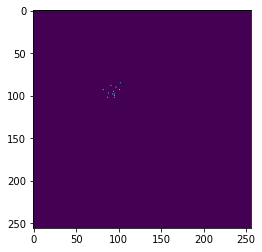

In [10]:
one_blob_map=np.zeros((256,256))
amplifying_factor=300
one_blob_map[random_blob[:,0], random_blob[:,1]] = amplifying_factor
plt.imshow(one_blob_map)

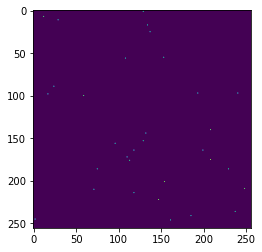

In [11]:
randmap = np.maximum(np.zeros((256,256)), np.random.binomial(n=1, p=0.0006,size=(256,256))*amplifying_factor)
plt.imshow(randmap)

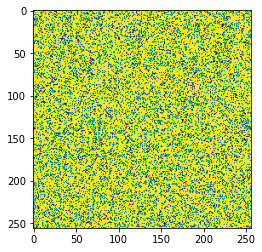

In [12]:
randmap = np.random.binomial(n=1, p=0.8,size=(256,256))
plt.imshow(randmap)

In [13]:
def dice_roll():
    return np.random.rand()

class MaskMapGenerator:

    def __init__(self,starting_map=None, gaussian_blob_prob=0.5, line_prob=0.2, amplifying_factor=300):
        self.current_map = np.zeros((256,256)) if starting_map is None else starting_map
        self.blobs = {}
        self.lines = {}
        self.total_iterator = 0
        self.gauss_prob = gaussian_blob_prob
        self.line_prob = line_prob
    
    def generate(self, n=100):
        for i in range(n):
            
            if dice_roll() < self.gauss_prob:
                new_blob = make_blob(n_samples=np.abs(np.random.randint(40)),size=256)
                self.current_map[new_blob[:,0], new_blob[:,1]] = amplifying_factor
                self.blobs[self.total_iterator] = new_blob
            elif dice_roll() < self.line_prob:
                new_line = make_line(256, 256, np.abs(np.random.randint(40)))
                self.current_map[new_line[:,0], new_line[:,1]] = amplifying_factor
                self.lines[self.total_iterator] = new_line
            else:
                self.current_map = np.maximum(self.current_map, np.random.binomial(n=1, p=0.0006,size=(256,256))*amplifying_factor)
            self.current_map *= np.random.binomial(n=1, p=0.8,size=(256,256))
            yield self.current_map
            self.total_iterator += 1

    

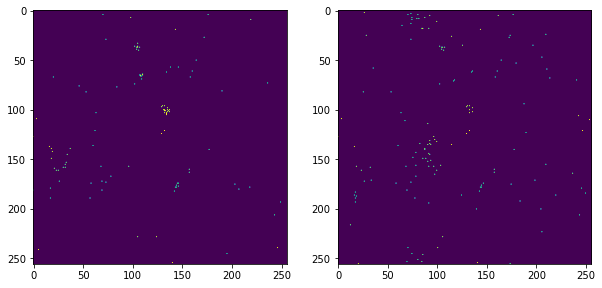

In [14]:

D = C = None
n = 0
m = 40
mgen = MaskMapGenerator(None, 0.5, 0.2)
for  i in mgen.generate(m):
    n += 1
    if n == m-4:
     C = i
    D = i
    
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

axis[0].imshow(C)
axis[1].imshow(D)

### Utility algorithms

In [15]:
def get_clusters(map_matrix, clustering_algorithm):
    map_points = np.array(
                    sorted(list(
                        zip(np.where(map_matrix != 0)[0],
                            np.where(map_matrix != 0)[1])
                    )))
    
    if len(map_points) == 0:
        return []
    
    clustering_algorithm.fit(map_points)
    clustered_points = np.hstack((
                                clustering_algorithm.labels_.reshape(-1,1),
                                map_points
                                ))
    return clustered_points

In [104]:
def measure_clusters(clustered_points):
    clusters=[]
    cluster_centroids=[]
    for cluster_number in np.sort(
                            np.unique(
                                clustered_points[:, 0]
                            )):
        if cluster_number != -1:
            
            points_of_cluster = clustered_points[np.where(clustered_points[:,0] == cluster_number), 1:] 
            points_of_cluster = np.squeeze(points_of_cluster)
            position, cluster_metrics = get_metrics(points_of_cluster)
            clusters.append(cluster_metrics)
            cluster_centroids.append(position)
    return np.array(cluster_centroids), np.array(clusters)


def get_metrics(cluster_points):
    #returns:
    # Position
    # Point count / avg
    # Blair-Bliss (density) 
    # Correlation coeffitience (roundness) 
    # Linear trend direction 
    position = cluster_points.mean(0)
    
    point_count = cluster_points.shape[0] / 100
    density = np.sqrt(
                np.sum(
                    (cluster_points - cluster_points.mean(0))**2, 1)
                ).mean()
    roundness = np.abs(np.corrcoef(cluster_points.T + np.random.normal(scale=1e-8 ,size=cluster_points.T.shape))[0,1])
    direction = np.arctan(LinearRegression() \
                .fit(
                    X = cluster_points[:, 0].reshape(-1,1), 
                    y = cluster_points[:, 1].reshape(-1,1)) \
                .coef_[0,0])
    return position, np.hstack((point_count,
                                density,
                                roundness,
                                direction))

    
def l2_axis_norm(M, axis=1):
    return (np.sum(np.abs(M)**2,axis=axis)**(1./2)
           ).reshape(-1,1)


def bi_directional_softmax(M):
    row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
    column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
    return (2*row_wise*column_wise)/(row_wise + column_wise)

def find_strong_max(M):
    maxed_M = np.zeros_like(M)
    for row_idx, row in enumerate(M):
        for col_idx, el in enumerate(row):
            if (el == np.max(M, axis=1)[row_idx]) and (el == np.max(M, axis=0)[col_idx]) and (el > 0.3):
                maxed_M[row_idx, col_idx] = 1
            else:
                maxed_M[row_idx, col_idx] = 0
    return maxed_M

        
def cluster_simmilarity(points_current, points_prev):
    curr_centroids, curr_map_metrics = measure_clusters(points_current)
    prev_centroids, prev_map_metrics = measure_clusters(points_prev)
    if len(prev_centroids) == 0 and len(curr_centroids) != 0:
        return np.zeros_like(curr_centroids), (None, None)
    elif len(curr_centroids) == 0 and len(prev_centroids) != 0:
        return np.zeros_like(prev_centroids), (None, None)
    elif len(prev_centroids) == 0 and len(curr_centroids) == 0:
        return None, (None, None)
    
    
    norm_matrix = l2_axis_norm(curr_map_metrics) @ (l2_axis_norm(prev_map_metrics)).T
    shape_simmilarity_matrix = curr_map_metrics @ prev_map_metrics.T * (norm_matrix**-1)
    print(shape_simmilarity_matrix)
    partstep = shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix))+0.01
    print("heeere")
    print(partstep)
    shape_simmilarity_matrix = bi_directional_softmax(partstep)
    print(shape_simmilarity_matrix)
    
    distance_matrix = np.sqrt(np.abs(
                                 np.sum(curr_centroids*curr_centroids, axis=1).reshape(-1,1) 
                               - 2*(curr_centroids @ prev_centroids.T) 
                               + np.sum(prev_centroids*prev_centroids, axis=1)
                       ))
    
    distance_matrix = (1/D_MIN) * np.clip(D_MIN - distance_matrix, a_min=0, a_max=D_MIN)
    simmilarity_matrix = (2*shape_simmilarity_matrix * distance_matrix)/(shape_simmilarity_matrix + distance_matrix)
    return simmilarity_matrix, (distance_matrix, shape_simmilarity_matrix)

In [101]:
dd = np.array([[849.03887384, 847.03887384],
 [847.03887385, 849.03887384]])

In [103]:
np.exp(dd)

/tmp/ipykernel_172660/3973071367.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(dd)


array([[inf, inf],
       [inf, inf]])

In [102]:
bi_directional_softmax(dd)

/tmp/ipykernel_172660/3629721334.py:50: RuntimeWarning: overflow encountered in exp
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
/tmp/ipykernel_172660/3629721334.py:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
/tmp/ipykernel_172660/3629721334.py:51: RuntimeWarning: overflow encountered in exp
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
/tmp/ipykernel_172660/3629721334.py:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)


array([[nan, nan],
       [nan, nan]])

In [73]:
A = B = None
n = 0
m = 40

mgen = MaskMapGenerator(None, 0.5, 0.2)
for  i in mgen.generate(m):
    n += 1
    if n == m-4:
        A = i
    B = i

dbscan = DBSCAN(5, min_samples=4)
simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, dbscan), get_clusters(A, dbscan))

[[0.85926807 0.99158122]]
[[0.21301396 0.93662106]]


# Comp-aring clustering algorithms

In [18]:
mgen = MaskMapGenerator(None, 0.5, 0.2)
n = 300
np.random.seed(1410)
allmaps =  [m for m in mgen.generate(n)]

In [76]:
def get_cluster_array(clstrs):
    only_clstrs = clstrs[clstrs[:,0] != -1]
    all_ids = np.unique(only_clstrs[:,0])
    cluster_array = []
    for clstr_id in all_ids:
        separate_cluster = only_clstrs[only_clstrs[:,0] == clstr_id]
        cluster_array.append(separate_cluster[:,-2:])
    return cluster_array
        


In [77]:
def showmap(m):
    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    cnames = ['A','B']
    centroids, _ = measure_clusters(get_clusters(m, dbscan))
    axis.imshow(m)
    for centr_number, centroid in enumerate(centroids):
        axis.set_title(cnames[0])
        axis.text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))

In [78]:
from sklearn.cluster import DBSCAN, OPTICS, Birch, MeanShift, AgglomerativeClustering
from collections import defaultdict
from tqdm.notebook import tqdm

optics = OPTICS(min_samples=4, max_eps=5)
birch = Birch()
ms = MeanShift()
aggc = AgglomerativeClustering(None, distance_threshold = 10)

dbscan = DBSCAN(5, min_samples=4)
clfs = [optics, dbscan] 
clf_metrics = []

blobsets = { k: set(tuple(pair) for pair in v) for k, v in mgen.blobs.items()}
linesets = { k: set(tuple(pair) for pair in v) for k, v in mgen.lines.items()}
acc_blobs = []
acc_lines = []
all_metrics = []

for clf in tqdm(clfs):
    metrics = defaultdict(list)
    blob_acc = defaultdict(list)
    line_acc = defaultdict(list)
    allmaps_possible_clusterpoints = []
    acc, mm, recall = [], [], []
    for i, m in tqdm(enumerate(allmaps)):
        clstrs = get_clusters(m, clf)
        arr = get_cluster_array(clstrs)
        possible = []
        backsee = 8
        allclustered = set(tuple(pair) for pair in clstrs[clstrs[:,0] != -1][:,-2:])
        tn = len(set(tuple(pair) for pair in clstrs[clstrs[:,0] == -1][:,-2:]))
        all_pixels = set(tuple(pair) for pair in clstrs[:,-2:])
        for kb, blob in mgen.blobs.items():
            if i >= kb and i - backsee < kb:
                possible.append(blob)
        for lb, line in mgen.lines.items():
             if i >= lb and i - backsee < lb:
                possible.append(line)
        all_possible_pixels = np.concatenate(possible) if len(possible)!=0 else np.array([])
        all_found_pixels = np.concatenate(arr) if len(arr)!=0 else np.array([])
        data1 = set(tuple(pair) for pair in all_possible_pixels)
        data2 = set(tuple(pair) for pair in all_found_pixels)
        for kb, blob in mgen.blobs.items():
            if i >= kb and i - backsee < kb:
                if blobsets[kb]:
                    blob_acc[kb].append(len(allclustered & blobsets[kb])/len(all_pixels))
        for lb, line in mgen.lines.items():
             if i >= lb and i - backsee < lb:
                if linesets[lb]:
                    line_acc[lb].append(len(allclustered & linesets[lb])/len(all_pixels))

        if possible:
            alld_a= np.array(list(all_pixels)) 
            alld_b = np.zeros((alld_a.shape[0], 3), dtype=int)
            alld_b[:,-2:] = alld_a
            match = [tuple(x[-2:]) in data1 for x in alld_b]
            alld_b[:,0][match] = 1
            alld_b = np.array(sorted([tuple(x) for x in alld_b], key=lambda x: x[-2:]))
            allmaps_possible_clusterpoints.append(alld_b)
        else:
            allmaps_possible_clusterpoints.append([])
        tp = len(data1 & data2) # present in generated data in and in found in clusters
        fp = len(data2 - data1) # not present in generated, but found
        fn = len(data1 - data2) # generated in the data, but not found
        tn = len(all_pixels - data1)
        metrics['tp'].append(tp)
        metrics['fp'].append(fp)
        metrics['fn'].append(fn)
        metrics['tn'].append(tn)
        acc.append((tp+tn)/len(all_pixels))
        recall.append(tp/(tp+fn) if tp+fn!=0 else 0)
        mm.append(tp/len(all_pixels))
    clf_metrics.append((acc, recall, mm))
    acc_blobs.append(blob_acc)
    acc_lines.append(line_acc)
    all_metrics.append(metrics)
            
    


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/mwm/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mwm/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mwm/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mwm/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mwm/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered ou

0it [00:00, ?it/s]

In [79]:
d = all_metrics[0]

summed_conf_mat = lambda x : {n:sum(x[n]) for n in ['tp', 'fn', 'fp', 'tn']}

def calc_fp_ratio(dat):
    met = summed_conf_mat(dat)
    return met['fp']/(met['fp']+ met['tn'])
    


In [80]:
print(calc_fp_ratio(all_metrics[0]))
print(calc_fp_ratio(all_metrics[1]))

0.1874091866085461
0.23371829646821957


In [81]:
[summed_conf_mat(all_metrics[i]) for i in range(2)]

[{'tp': 0, 'fn': 2944, 'fp': 6320, 'tn': 27403},
 {'tp': 0, 'fn': 2944, 'fp': 8358, 'tn': 27403}]

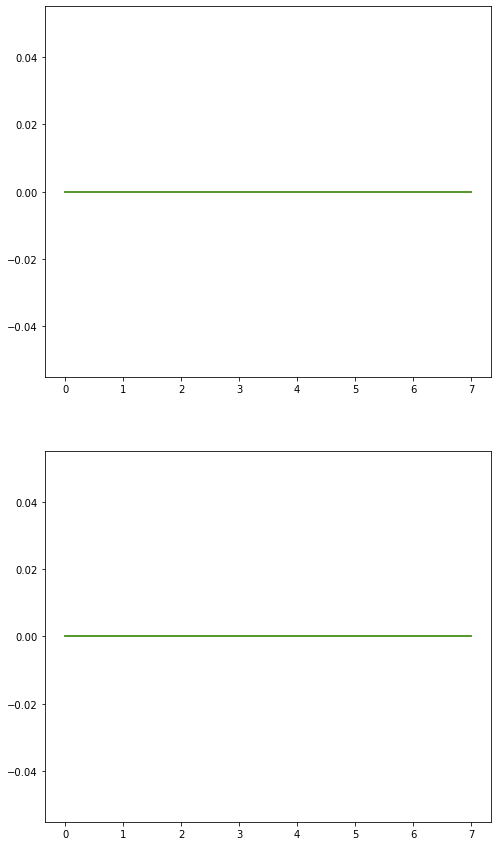

In [82]:
fig, axes = plt.subplots(2,1, figsize=(8,15))
for blobber, axe in zip(acc_lines,axes):
    for k,v in blobber.items():
        axe.plot(v)

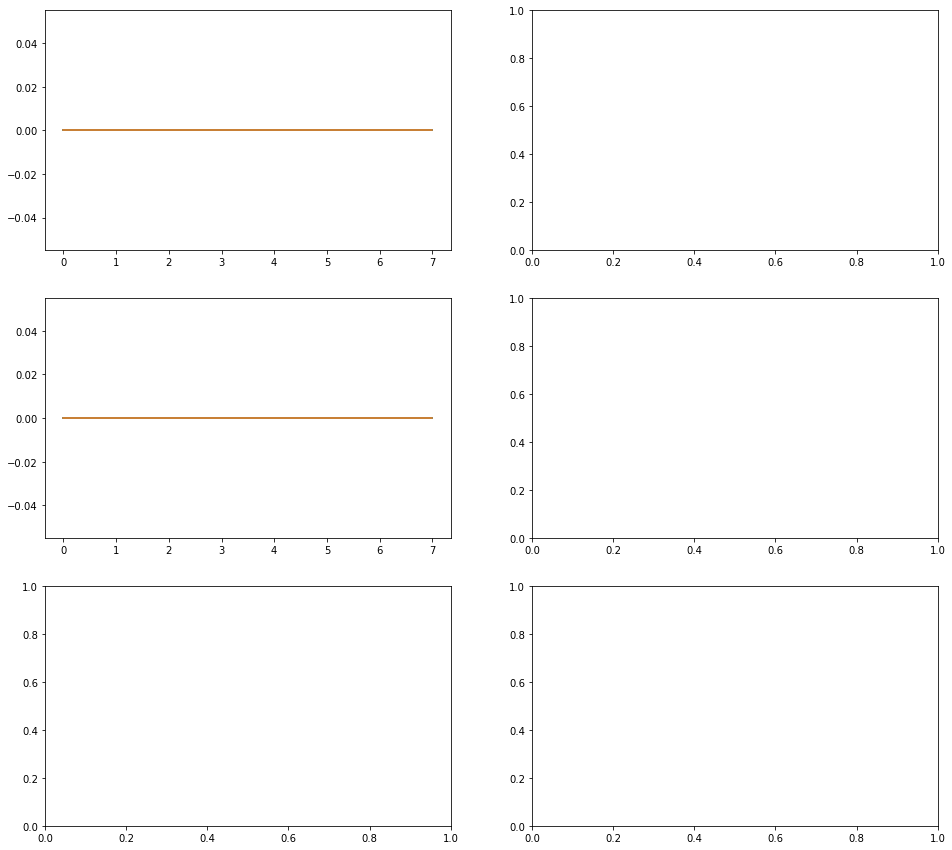

In [83]:
fig, axes = plt.subplots(3,2, figsize=(16,15))
for blobber, axe in zip(acc_blobs,axes):
    suma = 0
    for k,v in blobber.items():
        axe[0].plot(v)

IndexError: list index out of range

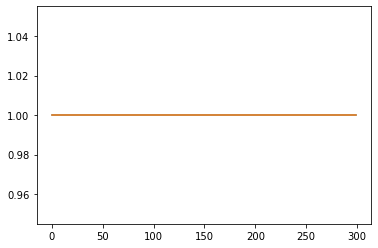

In [84]:
plt.plot(clf_metrics[0][0])
plt.plot(clf_metrics[1][0])
plt.plot(clf_metrics[2][0])
plt.plot(clf_metrics[3][0])

In [ ]:
plt.plot(clf_metrics[0][1])
plt.plot(clf_metrics[1][1])
plt.plot(clf_metrics[2][1])
plt.plot(clf_metrics[3][1])

In [ ]:
plt.plot(clf_metrics[0][2])
plt.plot(clf_metrics[1][2])
plt.plot(clf_metrics[2][2])
plt.plot(clf_metrics[3][2])

In [ ]:
acc

In [ ]:
label_mapping

In [ ]:
import ipywidgets as widgets

play = widgets.Play(
    value=0,
    min=0,
    max=len(allmaps),
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

def f(frame):
    fig, axes = plt.subplots(2,2, figsize=(12,12))
    B = allmaps[frame-1]
    A = allmaps[frame]
    for ax, clf in zip(axes, clfs):
        axis = ax
        centroids, _ = measure_clusters(get_clusters(B, clf))
        axis[0].imshow(B)
        for centr_number, centroid in enumerate(centroids):
            #axis[0].set_title(cnames[0])
            axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))

        centroids, _ = measure_clusters(get_clusters(A, clf))
        simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, clf), get_clusters(A, clf))
        axis[1].imshow(A)
        label_mapping = get_cluster_mapping(simmilarities)or {}
        print(label_mapping)
        for centr_number, centroid in enumerate(centroids):
            #axis[1].set_title(cnames[1])
            if centr_number in label_mapping.keys():
                name = str(label_mapping[centr_number])
            else:
                name = 'new'
            axis[1].text(x = centroid[1], y = centroid[0], s=name, bbox=dict(color='white', alpha=0.1))
    


slider = widgets.IntSlider(value=0, min=0, max=len(allmaps))
widgets.jslink((play, 'value'), (slider, 'value'))
out = widgets.interactive_output(f, {'frame': slider})
widgets.VBox([out, widgets.VBox([play, slider])])

In [ ]:
data_dbscan = []
clf = dbscan
for frame in range(1,len(allmaps)):
    B = allmaps[frame-1]
    A = allmaps[frame]
    centroids, _ = measure_clusters(get_clusters(A, clf))
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, clf), get_clusters(A, clf))
    label_mapping = get_cluster_mapping(simmilarities) if simmilarities is not None else {}
    old_clusters = 0
    new_clusters = 0
    for centr_number, centroid in enumerate(centroids):
        if centr_number in label_mapping.keys():
            old_clusters += 1
        else:
            new_clusters += 1
    data_dbscan.append((frame, old_clusters, new_clusters))

In [ ]:
data_optics = []
clf = optics
for frame in range(1,len(allmaps)):
    B = allmaps[frame-1]
    A = allmaps[frame]
    centroids, _ = measure_clusters(get_clusters(A, clf))
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, clf), get_clusters(A, clf))
    label_mapping = get_cluster_mapping(simmilarities) if simmilarities is not None else {}
    old_clusters = 0
    new_clusters = 0
    for centr_number, centroid in enumerate(centroids):
        if centr_number in label_mapping.keys():
            old_clusters += 1
        else:
            new_clusters += 1
    data_optics.append((frame, old_clusters, new_clusters))

In [ ]:
do = np.array(data_optics)
dd = np.array(data_dbscan)

In [ ]:
do[:,1].sum(), dd[:,1].sum()

In [ ]:
do[:,2].sum(), dd[:,2].sum()

In [ ]:
plt.plot(do[:,1])
plt.plot(do[:,2])

In [ ]:
plt.plot(dd[:,1])
plt.plot(dd[:,2])

In [ ]:
def categorised(map_matrix, clustering_algorithm):
    clustered_points = get_clusters(map_matrix, clustering_algorithm)
    clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
    clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
    return clustered_points

In [ ]:
clstrd = categorised(B, optics)

In [ ]:
from sklearn.metrics import log_loss
log_loss([0,1,1,1], [0,1,1,1])

In [ ]:
class metalern(OPTICS):
    def __init__(self,min_samples=5, max_eps=np.inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None):
        OPTICS.__init__(self, min_samples, max_eps, metric, p, metric_params, cluster_method, eps, xi, predecessor_correction, min_cluster_size, algorithm, leaf_size, n_jobs)
        
    def predict(self, x):
        self.fit(x)
        clustered_points = np.hstack((
                                self.labels_.reshape(-1,1),
                                x
                                ))
        clustered_points
        clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
        clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
        return clustered_points
        
        

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)



In [ ]:
def listify(map_matrix):
    map_points = np.array(
                    sorted(list(
                        zip(np.where(map_matrix != 0)[0],
                            np.where(map_matrix != 0)[1])
                    )))
    
    if len(map_points) == 0:
        return []
    else:
        return map_points

In [ ]:
real = [listify(x) for x in allmaps]
realy = [x[:,0] for x in allmaps_possible_clusterpoints]

In [ ]:
allmaps_possible_clusterpoints[0]

In [ ]:
img = np.zeros((256,256))
img[real[1][:,0],real[1][:,0]] = realy[1]
plt.imshow(img)

In [ ]:
real[1], realy[1]

In [ ]:
import itertools
for d in itertools.product((1,2,3),'abb','*=-'):
    print(d)

In [ ]:
from sklearn.metrics import log_loss, accuracy_score

grid_score = {}
for min_samples, metric, eps in tqdm(itertools.product((1,5,8),[ 'cosine', 'euclidean', 'l2'],[1.,5.,8.])):
    clf = OPTICS(min_samples=min_samples, metric=metric, eps=eps)
    cv_acc = []
    for x,y in tqdm(zip(real, realy)):
        clf.fit(x)
        clustered_points = np.hstack((
                                clf.labels_.reshape(-1,1),
                                x
                                ))
        clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
        clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
        ypred = clustered_points[:,0]
        cv_acc.append(accuracy_score(y, ypred))
    grid_score[(min_samples, metric, eps)] = np.mean(cv_acc)

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {
    'min_samples':[1,5,8], 
    'metric':[ 'cosine', 'euclidean',a 'l2'],
    'eps': [1., 5., 8.]
}
mtl = metalern()
clf = GridSearchCV(mtl, parameters, scoring="accuracy")
clf.fit(real[4], realy[4])



In [ ]:
clf.best_estimator_

# End compare

In [ ]:
dist

In [ ]:
centroids

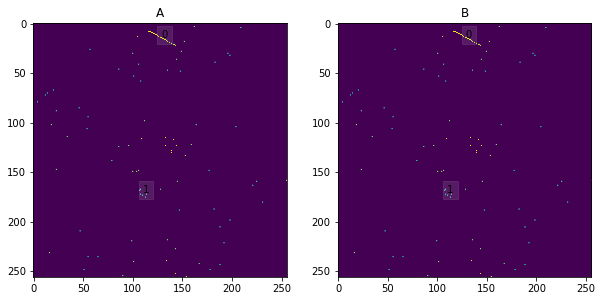

In [85]:


fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
cnames = ['A','B']
centroids, _ = measure_clusters(get_clusters(B, dbscan))
axis[0].imshow(B)
for centr_number, centroid in enumerate(centroids):
    axis[0].set_title(cnames[0])
    axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))
    
centroids, _ = measure_clusters(get_clusters(A, dbscan))
axis[1].imshow(A)
for centr_number, centroid in enumerate(centroids):
    axis[1].set_title(cnames[1])
    axis[1].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))

/home/mwm/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/mwm/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Text(609.9818181818181, 0.5, 'A')

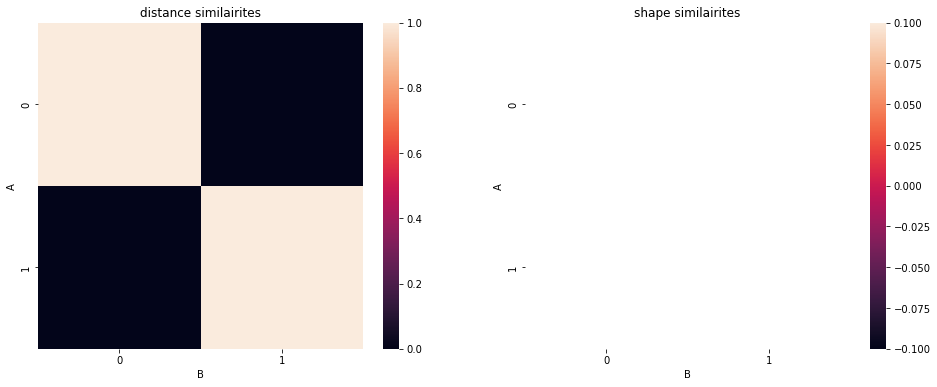

In [86]:
fig, axis = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(dist, ax = axis[0])
axis[0].set_title('distance similairites')
sns.heatmap(shape, ax = axis[1])
axis[1].set_title('shape similairites')
axis[0].set_xlabel('B')
axis[0].set_ylabel('A')
axis[1].set_xlabel('B')
axis[1].set_ylabel('A')

Text(51.0, 0.5, 'A')

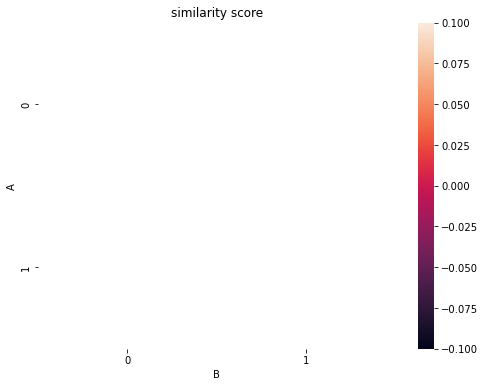

In [87]:
fig, axis = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(simmilarities, ax=axis)
axis.set_title('similarity score')
axis.set_xlabel('B')
axis.set_ylabel('A')

Text(51.0, 0.5, 'A')

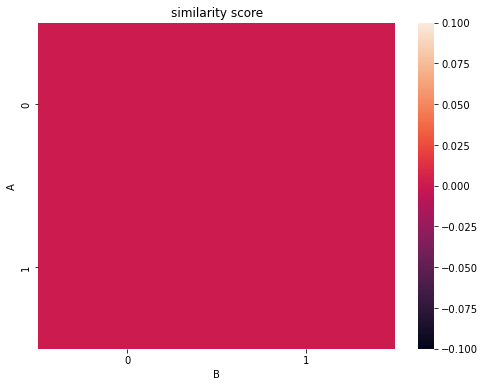

In [88]:
fig, axis = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(find_strong_max(simmilarities), ax=axis)
axis.set_title('similarity score')
axis.set_xlabel('B')
axis.set_ylabel('A')

In [89]:
def get_cluster_mapping(simmilarity_matrix):
    cluster_pairs =  {}
    for col_idx, column in enumerate(find_strong_max(simmilarity_matrix.T)):
        if np.max(column) == 1:
            cluster_pairs[col_idx] = np.argmax(column)
    return cluster_pairs

In [90]:
B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
True

True

In [92]:
bc2[:,1]

array([  8,   8,   8,   9,   9,  10,  10,  11,  11,  12,  13,  14,  14,
        15,  15,  16,  16,  17,  18,  19,  20,  21,  21,  22, 167, 168,
       172, 172, 173, 175])

In [93]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","black","red"])

In [94]:
label_mapping

{}

In [95]:
centroids

array([[ 14.04166667, 128.54166667],
       [171.16666667, 110.        ]])

[[0.91573806 0.91477515 0.90496564]
 [0.99374771 0.99796581 0.99607   ]]
heeere
[[21.70532516 21.68251235 21.45010903]
 [23.5535008  23.65343435 23.60851955]]
[[0.19801153 0.18193409 0.15140349]
 [0.46305062 0.4999619  0.48686503]]
[[0.         0.         0.        ]
 [0.         0.65263616 0.        ]]


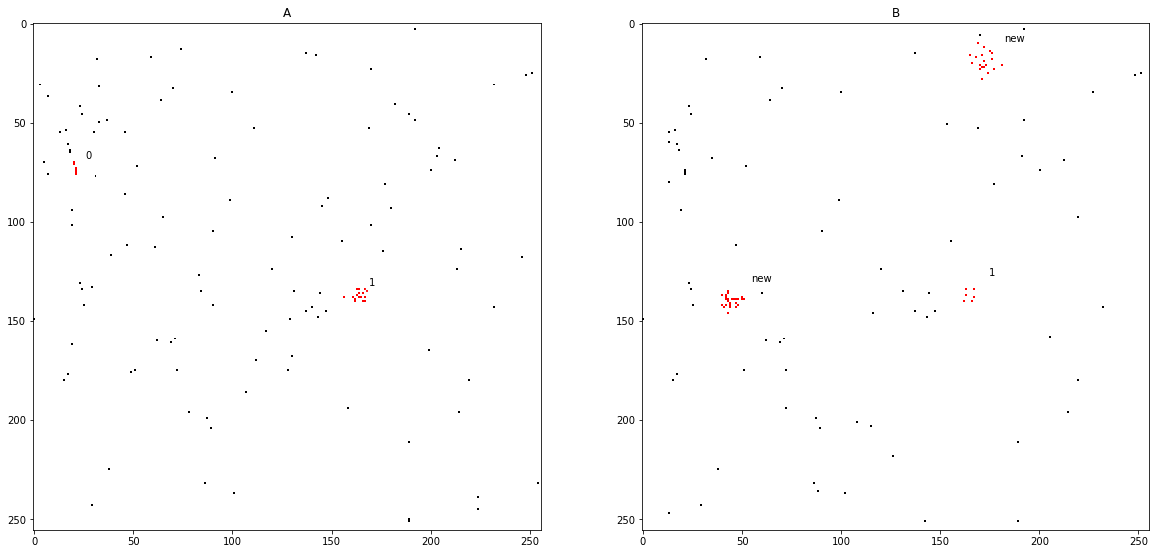

In [150]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
frame = 284
B = allmaps[frame-1]
A = allmaps[frame]
A_bin = A.copy()
B_bin = B.copy()
A_bin[A_bin!=0] = 1 
A_bin[A_bin==0] = 0 
B_bin[B_bin!=0] = 1 
B_bin[B_bin==0] = 0
bc = get_clusters(B, dbscan)
bc2 = bc[bc[:,0] != -1]
B_bin[bc2[:,1], bc2[:,2]] = 2
ac = get_clusters(A, dbscan)
ac2 = ac[ac[:,0] != -1]
A_bin[ac2[:,1], ac2[:,2]] = 2
centroids, _ = measure_clusters(bc)
axis[0].imshow(B_bin, cmap=cmap, interpolation='none')
for centr_number, centroid in enumerate(centroids):
    axis[0].set_title(cnames[0])
    axis[0].text(x = centroid[1]+5, y = centroid[0]-5, s=str(centr_number), bbox=dict(color='white', alpha=0.1))
    
centroids, _ = measure_clusters(ac)
axis[1].imshow(A_bin, cmap=cmap, interpolation='none')
simmilarities, (dist, shape) = cluster_simmilarity(bc, ac)
label_mapping = get_cluster_mapping(simmilarities)
print(simmilarities)
for centr_number, centroid in enumerate(centroids):
    axis[1].set_title(cnames[1])
    if centr_number in label_mapping.keys():
        name = str(label_mapping[centr_number])
    else:
        name = 'new'
    axis[1].text(x = centroid[1]+10, y = centroid[0]-10, s=name, bbox=dict(color='white', alpha=0.1))

[[0.91573806 0.91477515 0.90496564]
 [0.99374771 0.99796581 0.99607   ]]
heeere
[[21.70532548 21.68251266 21.45010934]
 [23.55350111 23.65343466 23.60851987]]
[[0.19801153 0.18193409 0.15140349]
 [0.46305062 0.4999619  0.48686503]]


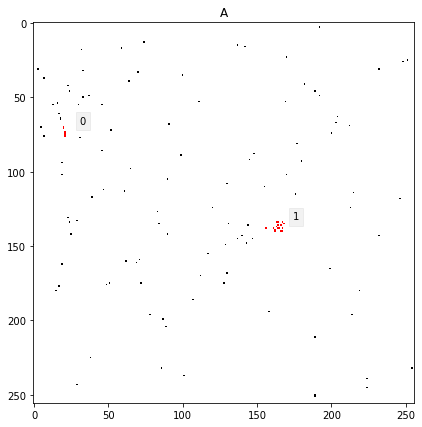

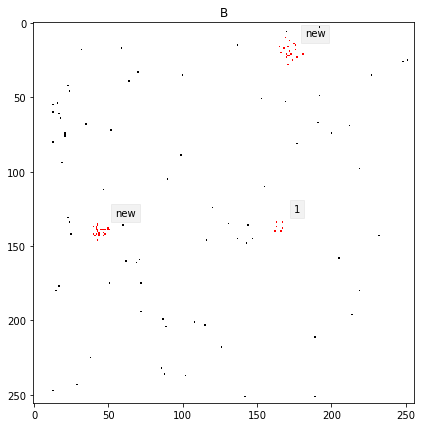

In [164]:
figsizenow = (7,7)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=figsizenow)
frame = 284
B = allmaps[frame-1]
A = allmaps[frame]
A_bin = A.copy()
B_bin = B.copy()
A_bin[A_bin!=0] = 1 
A_bin[A_bin==0] = 0 
B_bin[B_bin!=0] = 1 
B_bin[B_bin==0] = 0
bc = get_clusters(B, dbscan)
bc2 = bc[bc[:,0] != -1]
B_bin[bc2[:,1], bc2[:,2]] = 2
ac = get_clusters(A, dbscan)
ac2 = ac[ac[:,0] != -1]
A_bin[ac2[:,1], ac2[:,2]] = 2
centroids, _ = measure_clusters(bc)
axis.imshow(B_bin, cmap=cmap, interpolation='none')
for centr_number, centroid in enumerate(centroids):
    axis.set_title(cnames[0])
    axis.text(x = centroid[1]+10, y = centroid[0]-5, s=str(centr_number), bbox=dict(color='gray', alpha=0.1))
fig.savefig('pics/matching_A.pdf')
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=figsizenow)
centroids, _ = measure_clusters(ac)
axis.imshow(A_bin, cmap=cmap, interpolation='none')
simmilarities, (dist, shape) = cluster_simmilarity(bc, ac)
label_mapping = get_cluster_mapping(simmilarities)
for centr_number, centroid in enumerate(centroids):
    axis.set_title(cnames[1])
    if centr_number in label_mapping.keys():
        name = str(label_mapping[centr_number])
    else:
        name = 'new'
    axis.text(x = centroid[1]+10, y = centroid[0]-10, s=name, bbox=dict(color='gray', alpha=0.1))
fig.savefig('pics/matching_B.pdf')

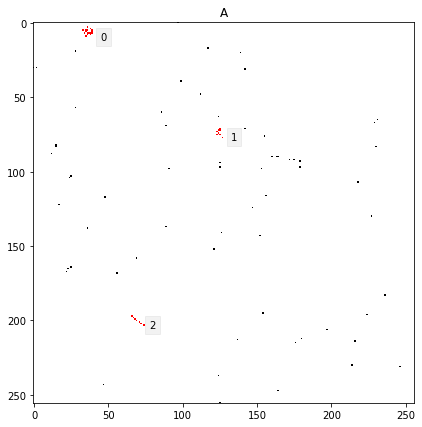

In [161]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
frame = 146
B = allmaps[frame-1]
A = allmaps[frame]
A_bin = A.copy()
B_bin = B.copy()
A_bin[A_bin!=0] = 1 
A_bin[A_bin==0] = 0 
B_bin[B_bin!=0] = 1 
B_bin[B_bin==0] = 0
bc = get_clusters(B, dbscan)
bc2 = bc[bc[:,0] != -1]
B_bin[bc2[:,1], bc2[:,2]] = 2
centroids, _ = measure_clusters(bc)
axis.imshow(B_bin, cmap=cmap, interpolation='none')
for centr_number, centroid in enumerate(centroids):
    axis.set_title(cnames[0])
    axis.text(x = centroid[1]+8, y = centroid[0]+5, s=str(centr_number), bbox=dict(color='gray', alpha=0.1))
fig.savefig('pics/example_clusters.pdf')

# Phase 1

### Novelty

In [146]:
def new_and_lost_clusters_between(curr_map, prev_map, dbscan):
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(curr_map, dbscan),
                                                       get_clusters(prev_map, dbscan))
    if simmilarities is None:
        return 0, 0
    
    cluster_pairs_matrix = find_strong_max(simmilarities)
    
    new = np.where(np.sum(cluster_pairs_matrix, axis = 0) == 0)[0].shape[0]
    lost = np.where(np.sum(cluster_pairs_matrix, axis = 1) == 0)[0].shape[0]
    return new, lost


def novelty_measures(curr_map, prev_map, dbscan):
    new_points_count = np.sum(np.clip(curr_map-prev_map, a_min=0, a_max=1))
    lost_points_count = np.sum(np.clip(prev_map-curr_map, a_min=0, a_max=1))
    
    number_of_new_clusters, number_of_lost_clusters = new_and_lost_clusters_between(curr_map, prev_map, dbscan)
    
    curr_clusters = get_clusters(curr_map, dbscan)
    curr_clusters = curr_clusters[np.where(curr_clusters[:,0] != -1)]
    prev_clusters = get_clusters(prev_map, dbscan)
    prev_clusters = prev_clusters[np.where(prev_clusters[:,0] != -1)]
    points_in_clusters_shared = np.vstack((curr_clusters, prev_clusters)).shape[0] \
                            - np.unique(np.vstack((curr_clusters, prev_clusters)), axis=0).shape[0]
    new_points_in_clusters_count = curr_clusters.shape[0] - points_in_clusters_shared
    lost_points_in_clusters_count = prev_clusters.shape[0] - points_in_clusters_shared
    
    return (new_points_count,
            lost_points_count,
            number_of_new_clusters,
            number_of_lost_clusters,
            new_points_in_clusters_count,
            lost_points_in_clusters_count)
    


In [147]:
novelty_measures(A, B, dbscan)

[[nan nan]
 [nan nan]]
[[1. 0.]
 [0. 1.]]
[[nan nan]
 [nan nan]]


/tmp/ipykernel_170726/393224960.py:50: RuntimeWarning: overflow encountered in exp
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
/tmp/ipykernel_170726/393224960.py:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
/tmp/ipykernel_170726/393224960.py:51: RuntimeWarning: overflow encountered in exp
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
/tmp/ipykernel_170726/393224960.py:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)


(0.0, 0.0, 2, 2, 0, 0)

### Outlierness

In [148]:
from sklearn.neighbors import NearestNeighbors

In [149]:
def local_density_imbalance(curr_map, n_neighbors):
    points = np.array(np.where(curr_map != 0)).T
    near_neigh = NearestNeighbors(n_neighbors=1+n_neighbors)
    near_neigh.fit(points)
    

    std_of_avg_knn_distance = np.std(np.mean(near_neigh.kneighbors(points)[0][:,1:], axis=1))
    return std_of_avg_knn_distance

def directional_density_imbalance(curr_map, n_neighbors):
    points = np.array(np.where(curr_map != 0)).T
    near_neigh = NearestNeighbors(n_neighbors=1+n_neighbors)
    near_neigh.fit(points)
    densities = np.sum(near_neigh.kneighbors(points)[0][:,1:], axis=1)
    lr = LinearRegression()
    lr.fit(X=points, y=densities)
    return lr.coef_

        
def outlierness_measures(curr_map, dbscan, n_neighbors=5):
    
    curr_clusters = get_clusters(curr_map, dbscan)
    curr_clusters = curr_clusters[np.where(curr_clusters[:,0] != -1)]
    number_of_clusters = np.unique(curr_clusters[:,0]).shape[0]
    total_points = np.where(curr_map != 0)[0].shape[0]
    points_in_clusters = curr_clusters.shape[0]
    total_points_normalized = total_points
    
    directional_imbalance_coef =  directional_density_imbalance(curr_map, n_neighbors)
    local_imbalance_coef = local_density_imbalance(curr_map, n_neighbors)
    
    x_directional_imbalance_coef, y_directional_imbalance_coef = directional_imbalance_coef
    return (number_of_clusters,
            points_in_clusters,
            total_points_normalized,
            x_directional_imbalance_coef,
            y_directional_imbalance_coef,
            local_imbalance_coef)
    


In [64]:
outlierness_measures(A, dbscan)

(1, 5, 71, 0.20251418262538753, 0.20041350690220738, 13.140967894216496)

In [65]:
num_trees = 150
tree_size = 16
shingle_size = 2

curr_map = np.zeros((256,256))
codisp_hist = []

forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

index = 0

lines = []
blobs = []

In [70]:
# Use the "shingle" generator to create rolling window
mgen = MaskMapGenerator(curr_map, 0.03, 0.02)
rgen = mgen.generate(n=600)
#rgen = randmap_generator(gaussian_blob_prob=0.03, line_prob=0.02, n=600, starting_map=curr_map)
# Create a dict to store anomaly score of each point
rgen_shingled = rrcf.shingle(rgen, size=shingle_size)
# For each shingle...
start = True
novelties = []
for rmap in rgen_shingled:
    #print(rmap.shape)
    if start is True:
        start = False
        pass
    else:
        rmap_measures = novelty_measures(curr_map = rmap[1], prev_map=rmap[0], dbscan=dbscan)
        novelties.append(rmap_measures)
        codisps = []
        for tree in forest:
            new_index = np.random.randint(tree_size)
            if len(tree.leaves) > tree_size:
                tree.forget_point(new_index)
                tree.insert_point(rmap_measures, index=new_index)
                codisps.append(tree.codisp(new_index))
            else:
                tree.insert_point(rmap_measures, index=index)
                codisps.append(tree.codisp(index))
        new_codisp = np.mean(codisps)
#         print(new_codisp)
        codisp_hist.append(new_codisp)
        index += 1

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = np.exp(M) / np.sum(np.exp(M), axis=1).reshape(-1,1)
<ipython-input-45-a4641898d7d9>:78: RuntimeWarning: divide by zero encountered in true_divide
  shape_simmilarity_matrix = bi_directional_softmax(shape_simmilarity_matrix/(np.std(shape_simmilarity_matrix)))
<ipython-input-45-a4641898d7d9>:50: RuntimeWarning: invalid value encountered in true_divide
  row_wise = np.exp(M) / np.sum(np.exp(M), axis=0).reshape(1,-1)
<ipython-input-45-a4641898d7d9>:51: RuntimeWarning: invalid value encountered in true_divide
  column_wise = 

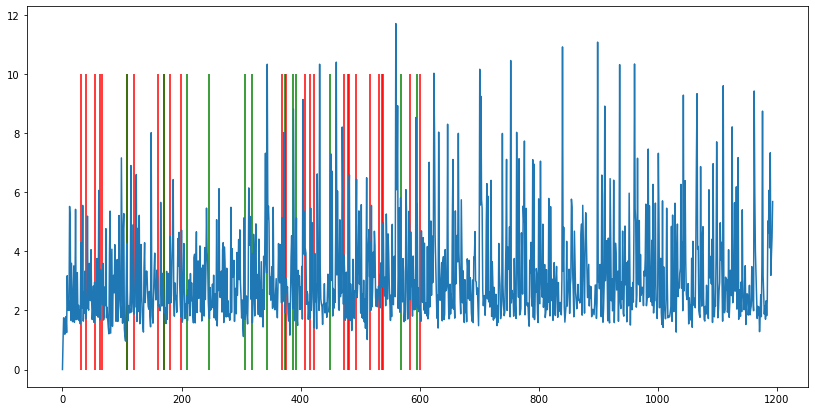

In [71]:
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(codisp_hist)
ax1.vlines(mgen.blobs.keys(), ymin=0, ymax=10, colors='red')
ax1.vlines(mgen.lines.keys(), ymin=0, ymax=10, colors='green')

In [41]:
np.array(novelties)[lines]

array([], shape=(0, 6), dtype=float64)

In [42]:
np.array(novelties)[blobs]

array([], shape=(0, 6), dtype=float64)

In [43]:
novelties

[(41.0, 7.0, 1, 1, 0, 4),
 (32.0, 17.0, 1, 1, 0, 1),
 (0.0, 0.0, 0, 0, 0, 0),
 (34.0, 18.0, 0, 0, 0, 7),
 (30.0, 24.0, 2, 2, 0, 9),
 (29.0, 16.0, 2, 1, 4, 0),
 (26.0, 23.0, 2, 1, 0, 4),
 (0.0, 0.0, 0, 0, 0, 0),
 (0.0, 0.0, 1, 1, 0, 0),
 (0.0, 0.0, 1, 1, 0, 0),
 (30.0, 12.0, 1, 1, 0, 1),
 (32.0, 16.0, 1, 1, 0, 1),
 (32.0, 32.0, 2, 1, 0, 7),
 (30.0, 25.0, 0, 0, 0, 0),
 (32.0, 24.0, 0, 0, 0, 0),
 (0.0, 0.0, 1, 1, 0, 0),
 (33.0, 16.0, 1, 1, 0, 3),
 (0.0, 0.0, 1, 1, 0, 0),
 (30.0, 27.0, 1, 1, 0, 1),
 (22.0, 26.0, 1, 1, 0, 0),
 (24.0, 20.0, 1, 1, 0, 0),
 (27.0, 27.0, 1, 1, 1, 0),
 (22.0, 26.0, 1, 1, 0, 1),
 (0.0, 0.0, 1, 1, 0, 0),
 (33.0, 24.0, 1, 1, 0, 5),
 (42.0, 27.0, 1, 1, 1, 3),
 (0.0, 0.0, 1, 1, 0, 0),
 (34.0, 28.0, 1, 1, 0, 7),
 (0.0, 0.0, 1, 1, 0, 0),
 (29.0, 24.0, 1, 1, 0, 4),
 (33.0, 20.0, 1, 1, 0, 1),
 (34.0, 11.0, 0, 1, 12, 10),
 (27.0, 36.0, 0, 0, 0, 3),
 (0.0, 0.0, 1, 1, 0, 0),
 (27.0, 18.0, 2, 1, 0, 4),
 (32.0, 29.0, 0, 0, 0, 0),
 (27.0, 27.0, 0, 0, 0, 0),
 (24.0, 24.0, 0, 0, 

In [44]:
blobs

[]

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

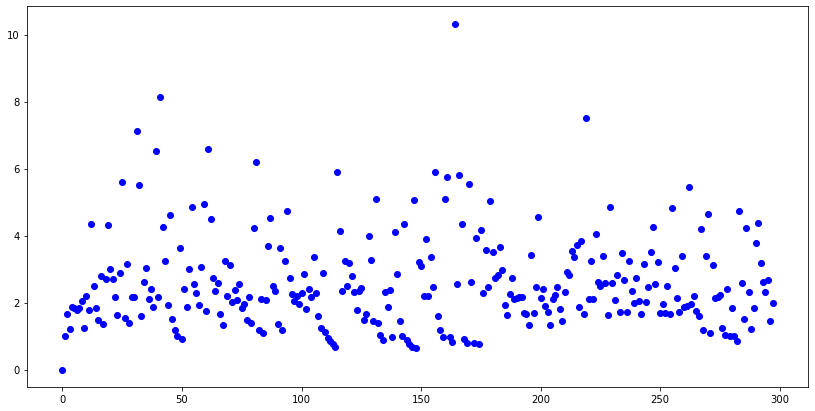

In [45]:
values = np.array(codisp_hist)
index = np.array(range(len(codisp_hist)))
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(values, marker='o', linestyle="None", color='blue')
ax1.plot(mgen.blobs, values[blobs], marker='o', linestyle="None", color='red')
ax1.plot(mgen.lines, values[lines], marker='o', linestyle="None", color='yellow')

In [42]:
values[blobs]

array([2.42      , 5.835     , 6.41      , 5.72      , 6.45      ,
       6.015     , 2.44      , 5.92      , 3.93266667, 5.96      ,
       5.315     , 6.65      , 2.361     , 5.895     , 6.365     ,
       5.465     , 5.865     ])